In [2]:
import numpy as np
from scipy.stats import beta

class MultiProductEnvironment:
    def __init__(self, k, T, a_vec, b_vec):
        """
        :param k: Number of product streams
        :param T: Time horizon
        :param a_vec: List or array of length k, alpha (a) parameters for each product's Beta distribution
        :param b_vec: List or array of length k, beta (b) parameters for each product's Beta distribution
        """
        self.k = k
        self.T = T
        self.a = np.array(a_vec)
        self.b = np.array(b_vec)

        if len(self.a) != k or len(self.b) != k:
            raise ValueError("Length of a_vec and b_vec must match k.")

        self.current_round = 0

    def reset(self):
        self.current_round = 0

    def play_round(self):
        """
        Returns a valuation vector: one sampled Beta value for each product stream.
        """
        if self.current_round >= self.T:
            raise StopIteration("Time horizon exceeded.")
        
        self.current_round += 1
        valuations = beta.rvs(self.a, self.b)
        return valuations


In [3]:
# Example with 3 product types, each with a different Beta distribution
k = 1
T = 100
a_vec = [2]
b_vec = [3]

env = MultiProductEnvironment(k=k, T=T, a_vec=a_vec, b_vec=b_vec)

# Sample a few rounds
for _ in range(5):
    print(env.play_round())

0.29664981646801986
0.3398206174843831
0.3354324489691858
0.5739665444870357
0.5749574961233165


In [4]:
import numpy as np
from itertools import product
from scipy.optimize import linprog
from scipy.stats import beta


class MultiProductBudgetedOracleAgent:
    def __init__(self, arm_values_per_product, a_params, b_params, T, B):
        """
        arm_values_per_product: List of lists, each sublist contains arm values (prices) for one product.
        a_params, b_params: Lists of Beta distribution parameters for each product.
        T: Time horizon
        B: Total budget
        """
        self.arm_values_per_product = arm_values_per_product
        self.a_params = a_params
        self.b_params = b_params
        self.k = len(arm_values_per_product)   # number of products
        self.T = T
        self.B = B
        self.remaining_budget = B
        self.round = 0

        # Compute expected reward and success probabilities for each arm
        self.expected_rewards_per_product = []
        self.success_probs_per_product = []

        for product_idx in range(self.k):
            a, b = a_params[product_idx], b_params[product_idx]
            values = arm_values_per_product[product_idx]
            success_probs = [1 - beta.cdf(v, a, b) for v in values]
            expected_rewards = [p * v for p, v in zip(success_probs, values)]

            self.success_probs_per_product.append(success_probs)
            self.expected_rewards_per_product.append(expected_rewards)

        # Generate all possible superarms (power set excluding combinations with more than one arm per product)
        self.superarms = self._generate_superarms()

    def _generate_superarms(self):
        """
        Each element is a tuple of indices (or None) of selected arms per product.
        For example, (0, None, 2) means: play arm 0 for product 0, skip product 1, play arm 2 for product 2.
        """
        options_per_product = [
            [None] + list(range(len(arms)))
            for arms in self.arm_values_per_product
        ]
        return list(product(*options_per_product))

    def choose_superarm(self):
        if self.round >= self.T or self.remaining_budget <= 0:
            return None

        rounds_remaining = self.T - self.round
        rho = self.remaining_budget / rounds_remaining  # max expected budget per round

        num_superarms = len(self.superarms)
        expected_rewards = []
        expected_costs = []

        for sa in self.superarms:
            total_reward = 0
            total_cost = 0
            for prod_idx, arm_idx in enumerate(sa):
                if arm_idx is not None:
                    total_reward += self.expected_rewards_per_product[prod_idx][arm_idx]
                    total_cost += self.success_probs_per_product[prod_idx][arm_idx]
            expected_rewards.append(total_reward)
            expected_costs.append(total_cost)

        # LP: maximize sum x_i * reward_i  subject to sum x_i * cost_i <= rho, sum x_i = 1, 0 <= x_i <= 1
        c = -np.array(expected_rewards)
        A = [expected_costs]
        b = [rho]
        A_eq = [np.ones(num_superarms)]
        b_eq = [1]
        bounds = [(0, 1) for _ in range(num_superarms)]

        res = linprog(c, A_ub=A, b_ub=b, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")

        if not res.success:
            # fallback: choose no products
            return tuple([None] * self.k)

        x = res.x
        index = np.random.choice(num_superarms, p=x)
        chosen_superarm = self.superarms[index]
        return chosen_superarm

    def update(self, chosen_superarm, valuation_vector):
        """
        chosen_superarm: tuple of selected arm indices (or None) per product
        valuation_vector: sampled valuations from environment
        """
        sales_this_round = 0
        reward = 0

        for prod_idx, arm_idx in enumerate(chosen_superarm):
            if arm_idx is None:
                continue
            price = self.arm_values_per_product[prod_idx][arm_idx]
            if valuation_vector[prod_idx] >= price:
                sales_this_round += 1
                reward += price

        self.remaining_budget -= sales_this_round
        self.round += 1
        return reward, sales_this_round


In [5]:
def simulate_multi_product(env, agent):
    """
    Simulates the interaction between the multi-product environment and the oracle agent.

    Parameters:
        env: The multi-product environment instance (must implement .reset() and .play_round()).
        agent: An instance of MultiProductBudgetedOracleAgent.

    Returns:
        total_reward: Cumulative reward obtained by the agent.
        history: List of tuples (round_index, chosen_superarm, valuation_vector, reward_this_round, budget_left).
    """
    history = []
    total_reward = 0

    env.reset()
    
    for t in range(agent.T):
        if agent.remaining_budget <= 0:
            break

        # Oracle chooses a superarm
        chosen_superarm = agent.choose_superarm()
        if chosen_superarm is None:
            break

        # Environment returns a valuation vector
        valuation_vector = env.play_round()

        # Agent updates based on observed valuation vector
        reward, sales = agent.update(chosen_superarm, valuation_vector)

        total_reward += reward

        history.append((
            t,
            chosen_superarm,
            valuation_vector,
            reward,
            agent.remaining_budget
        ))

    return total_reward, history



=== SIMULATION SUMMARY ===
Total reward: 881.6
Budget depleted at round 1999 of 2000.



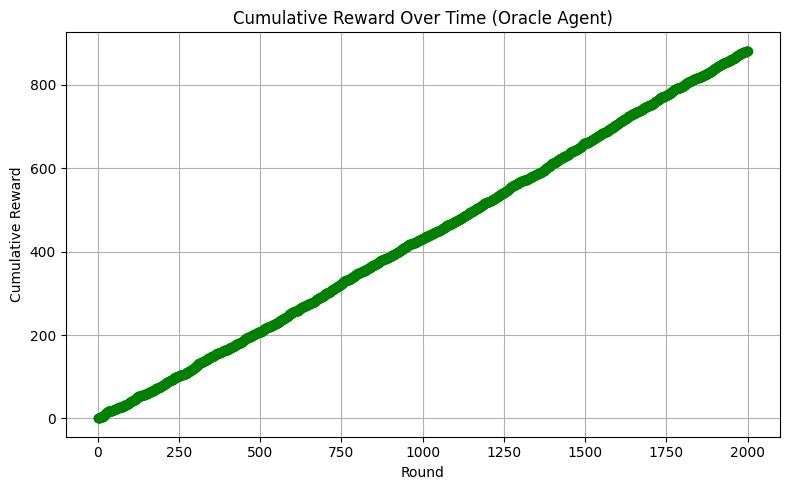

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# --- Setup ---
k = 3  # number of products
T = 2000
B = 2000
a_vec = [2, 3, 5]
b_vec = [5, 4, 2]
arm_values_per_product = [
    [0.2, 0.4, 0.6],
    [0.3, 0.5, 0.7],
    [0.1, 0.3, 0.9]
]

# Instantiate environment and oracle
env = MultiProductEnvironment(k=k, T=T, a_vec=a_vec, b_vec=b_vec)
oracle = MultiProductBudgetedOracleAgent(
    arm_values_per_product=arm_values_per_product,
    a_params=a_vec,
    b_params=b_vec,
    T=T,
    B=B
)

# Run simulation
total_reward, history = simulate_multi_product(env, oracle)

# --- Diagnostics ---
final_round = len(history)
final_budget = history[-1][-1] if history else B

print("\n=== SIMULATION SUMMARY ===")
print(f"Total reward: {total_reward:.1f}")
if final_budget <= 0:
    print(f"Budget depleted at round {final_round - 1} of {T}.")
else:
    print(f"Budget NOT depleted. Budget remaining: {final_budget} units.")
print("==========================\n")

# --- Plot: Cumulative Reward ---
cumulative_rewards = np.cumsum([reward for _, _, _, reward, _ in history])
rounds = np.arange(1, len(cumulative_rewards) + 1)

plt.figure(figsize=(8, 5))
plt.plot(rounds, cumulative_rewards, marker='o', linestyle='-', color='green')
plt.title("Cumulative Reward Over Time (Oracle Agent)")
plt.xlabel("Round")
plt.ylabel("Cumulative Reward")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
import numpy as np
from itertools import product
from scipy.optimize import linprog
import math


class MultiProductBudgetedUCBAgent:
    def __init__(self, arm_values_per_product, T, B):
        self.arm_values_per_product = arm_values_per_product
        self.T = T
        self.B = B
        self.k = len(arm_values_per_product)
        self.n_arms = len(arm_values_per_product[0])  # assuming all have same length
        self.remaining_budget = B
        self.round = 0

        # Superarms: same as in oracle
        self.superarms = self._generate_superarms()

        # Track stats: plays, successes, rewards
        self.arm_play_count = np.zeros((self.k, self.n_arms))
        self.arm_success_count = np.zeros((self.k, self.n_arms))
        self.arm_reward_sum = np.zeros((self.k, self.n_arms))

    def _generate_superarms(self):
        options_per_product = [
            [None] + list(range(len(arms)))
            for arms in self.arm_values_per_product
        ]
        return list(product(*options_per_product))

    def choose_superarm(self):
        if self.round >= self.T or self.remaining_budget <= 0:
            return None

        # Initialization phase: play each index once (across all streams)
        if self.round < self.n_arms:
            return tuple(
                i if i < len(self.arm_values_per_product[p]) else None
                for p, i in enumerate([self.round] * self.k)
            )

        # --- UCB Reward / LCB Cost Estimation ---
        ucb_rewards = [[0] * self.n_arms for _ in range(self.k)]
        lcb_costs = [[0] * self.n_arms for _ in range(self.k)]

        for p in range(self.k):
            for a in range(self.n_arms):
                n = self.arm_play_count[p][a]
                if n == 0:
                    ucb_rewards[p][a] = float("inf")
                    lcb_costs[p][a] = 0
                    continue
                avg_reward = self.arm_reward_sum[p][a] / n
                success_prob = self.arm_success_count[p][a] / n

                # Use Hoeffding-type bounds
                delta = 1 / self.T
                bonus = math.sqrt(2 * math.log(1 / delta) / n)

                ucb_rewards[p][a] = min(1.0, avg_reward + bonus)
                lcb_costs[p][a] = max(0.0, success_prob - bonus)

        # --- Solve LP with UCB and LCB estimates ---
        rounds_remaining = self.T - self.round
        rho = self.remaining_budget / rounds_remaining
        num_superarms = len(self.superarms)
        expected_rewards = []
        expected_costs = []

        for sa in self.superarms:
            total_reward = 0
            total_cost = 0
            for p, a in enumerate(sa):
                if a is not None:
                    total_reward += ucb_rewards[p][a]
                    total_cost += lcb_costs[p][a]
            expected_rewards.append(total_reward)
            expected_costs.append(total_cost)

        # LP: maximize expected reward under expected cost constraint
        c = -np.array(expected_rewards)
        A = [expected_costs]
        b = [rho]
        A_eq = [np.ones(num_superarms)]
        b_eq = [1]
        bounds = [(0, 1) for _ in range(num_superarms)]

        res = linprog(c, A_ub=A, b_ub=b, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")

        if not res.success:
            return tuple([None] * self.k)

        x = res.x
        index = np.random.choice(num_superarms, p=x)
        return self.superarms[index]

    def update(self, chosen_superarm, valuation_vector):
        sales_this_round = 0
        reward = 0

        for p, a in enumerate(chosen_superarm):
            if a is None:
                continue

            price = self.arm_values_per_product[p][a]
            self.arm_play_count[p][a] += 1

            if valuation_vector[p] >= price:
                self.arm_success_count[p][a] += 1
                self.arm_reward_sum[p][a] += price
                reward += price
                sales_this_round += 1

        self.remaining_budget -= sales_this_round
        self.round += 1
        return reward, sales_this_round



=== SIMULATION SUMMARY ===
Total reward: 711.6
Budget depleted at round 1804 of 2000.



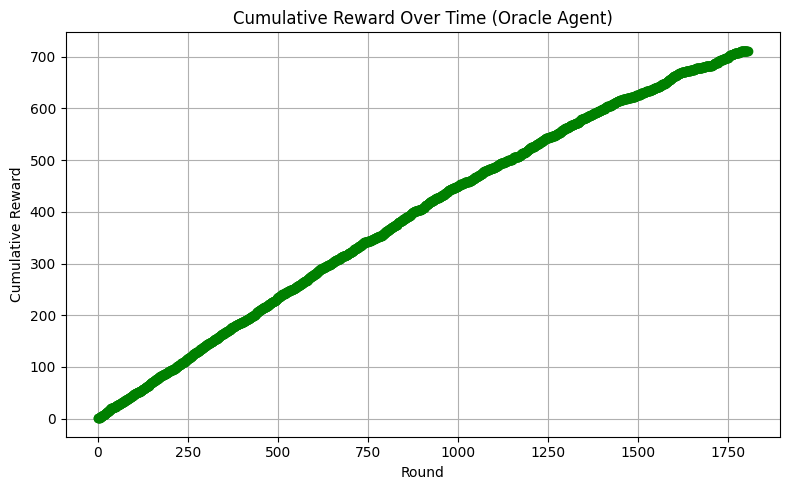

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# --- Setup ---
k = 3  # number of products
T = 2000
B = 2000
a_vec = [2, 3, 5]
b_vec = [5, 4, 2]
arm_values_per_product = [
    [0.2, 0.4, 0.6],
    [0.3, 0.5, 0.7],
    [0.1, 0.3, 0.9]
]

# Instantiate environment and oracle
env = MultiProductEnvironment(k=k, T=T, a_vec=a_vec, b_vec=b_vec)
agent = MultiProductBudgetedUCBAgent(
    arm_values_per_product=arm_values_per_product,
    T=T,
    B=B
)


# Run simulation
total_reward, history = simulate_multi_product(env, agent)

# --- Diagnostics ---
final_round = len(history)
final_budget = history[-1][-1] if history else B

print("\n=== SIMULATION SUMMARY ===")
print(f"Total reward: {total_reward:.1f}")
if final_budget <= 0:
    print(f"Budget depleted at round {final_round - 1} of {T}.")
else:
    print(f"Budget NOT depleted. Budget remaining: {final_budget} units.")
print("==========================\n")

# --- Plot: Cumulative Reward ---
cumulative_rewards = np.cumsum([reward for _, _, _, reward, _ in history])
rounds = np.arange(1, len(cumulative_rewards) + 1)

plt.figure(figsize=(8, 5))
plt.plot(rounds, cumulative_rewards, marker='o', linestyle='-', color='green')
plt.title("Cumulative Reward Over Time (Oracle Agent)")
plt.xlabel("Round")
plt.ylabel("Cumulative Reward")
plt.grid(True)
plt.tight_layout()
plt.show()


=== SIMULATION SUMMARY ===
Oracle total reward: 201.7
UCB agent total reward: 126.9
Reward ratio (UCB / Oracle): 0.629
Oracle: Budget depleted at round 999 of 1000.
UCB: Budget depleted at round 507 of 1000.



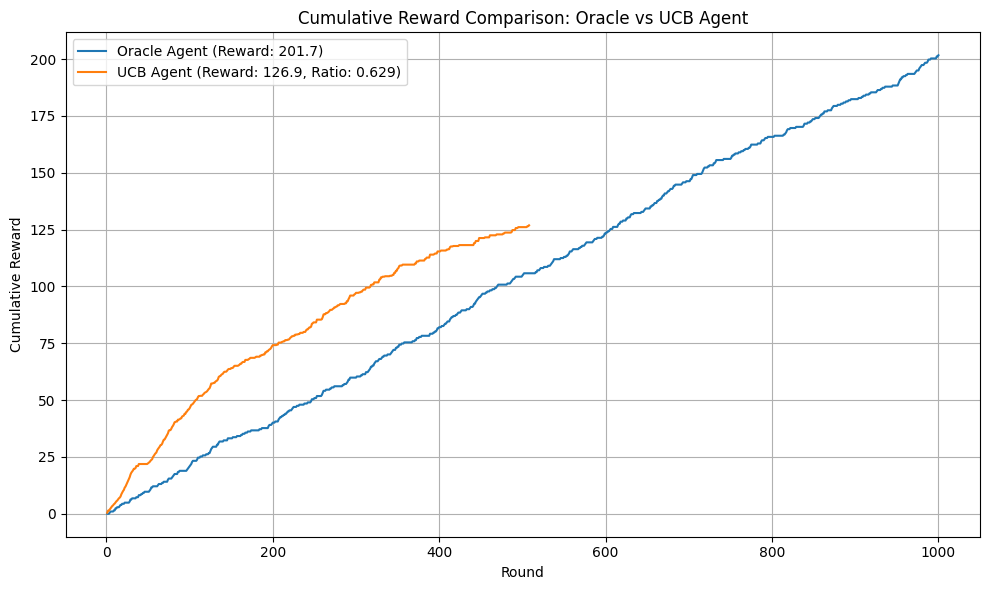

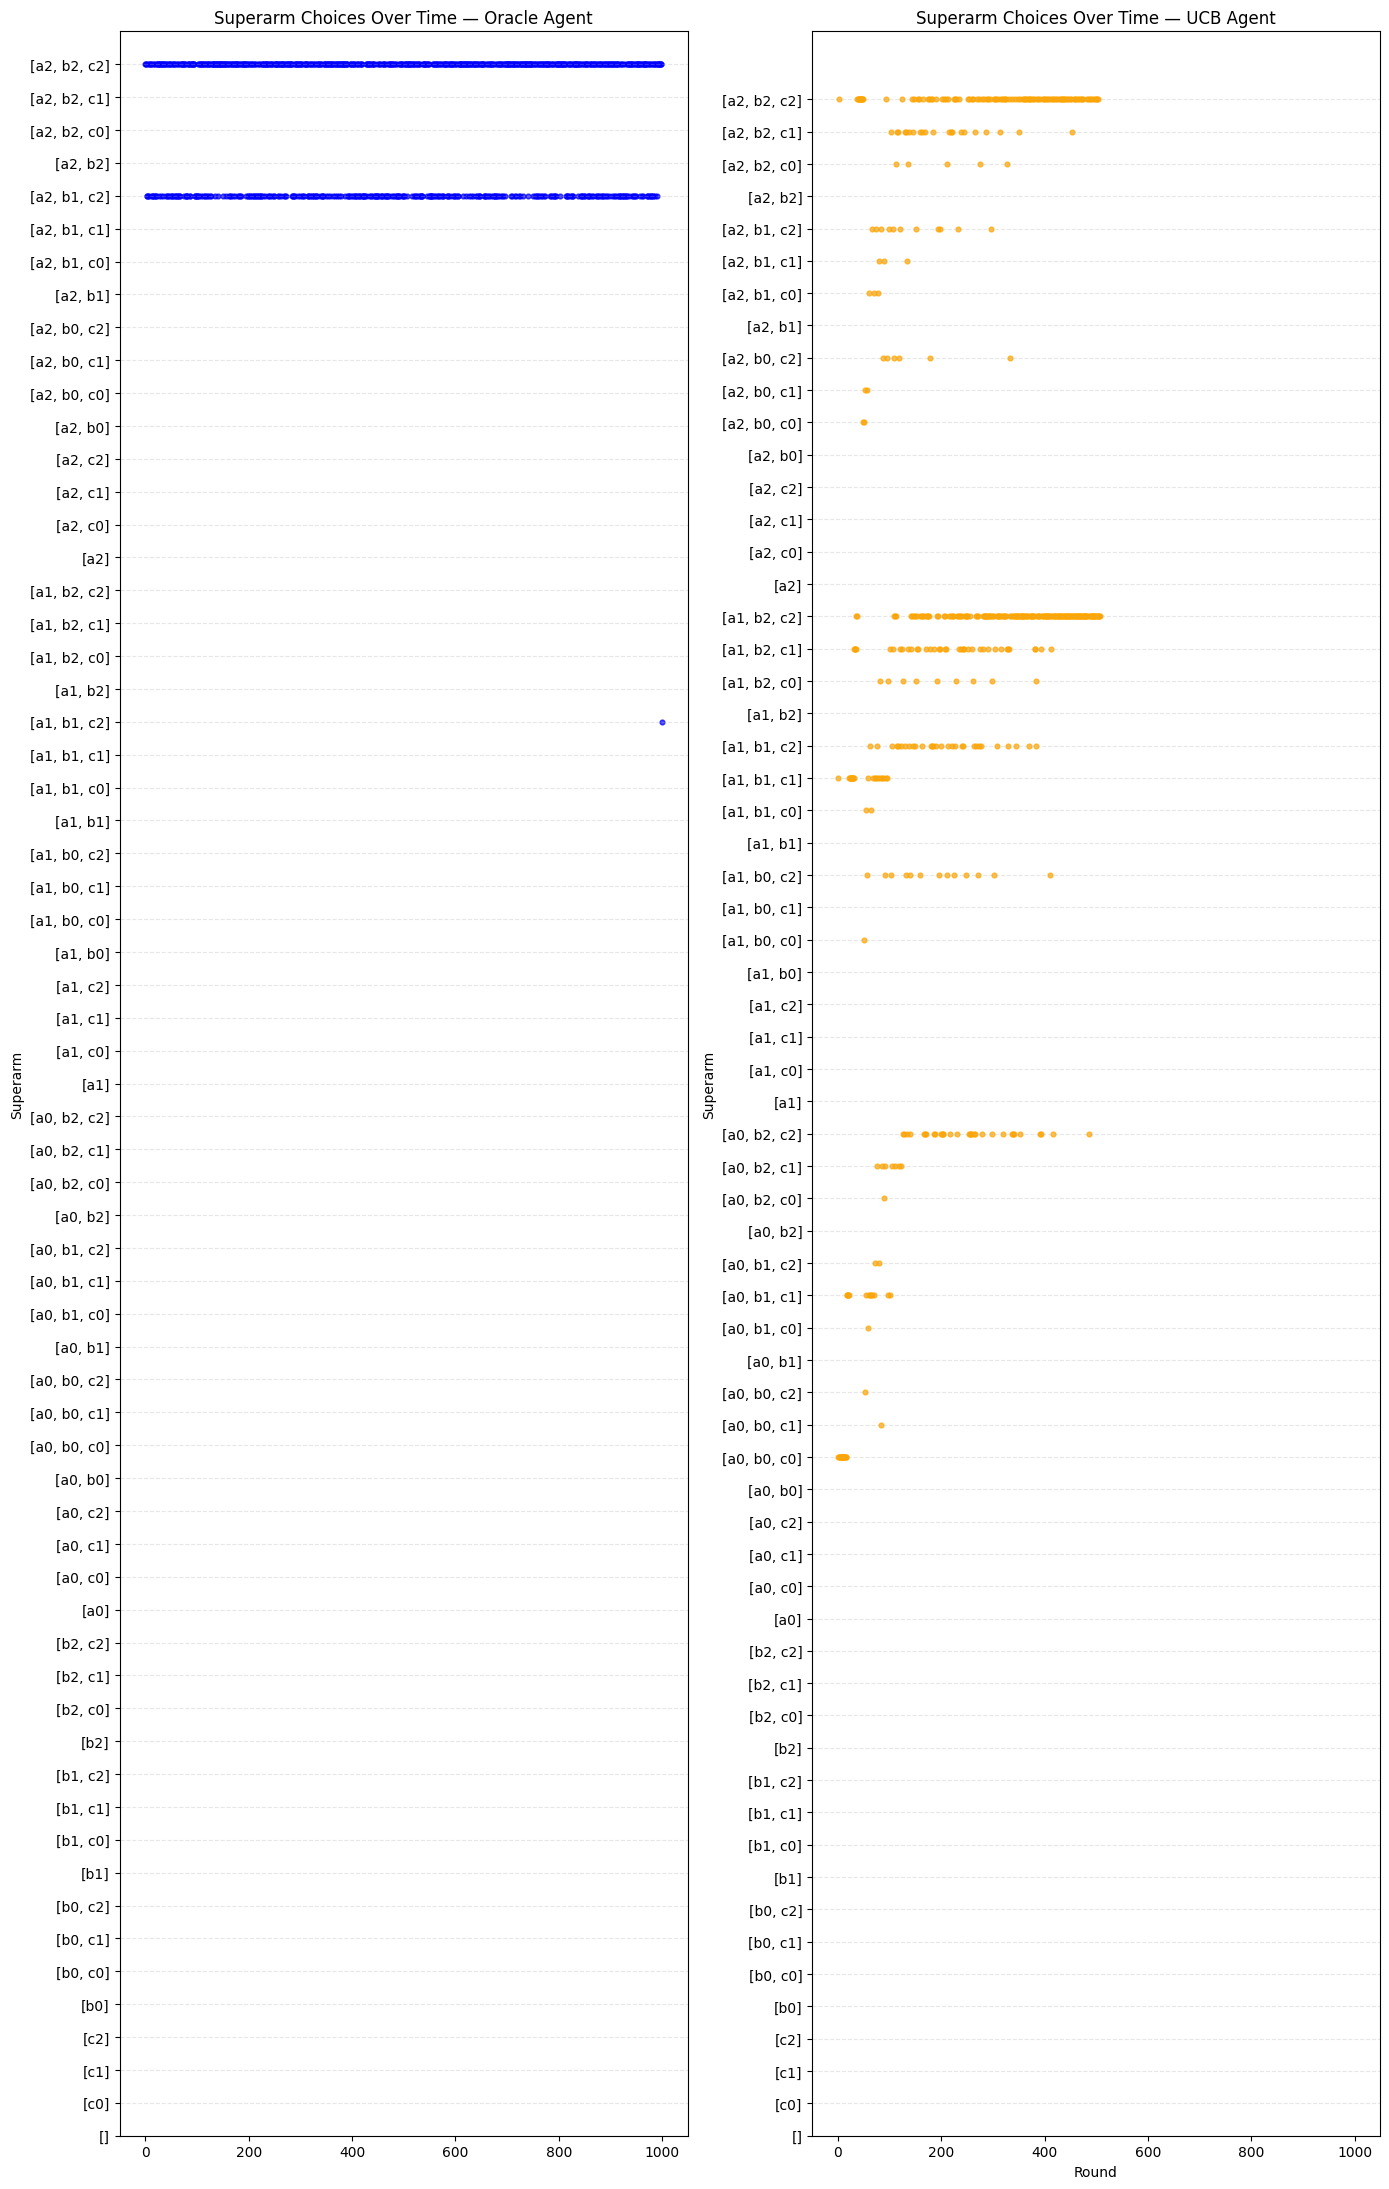

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# --- Setup ---
k = 3  # number of products
T = 1000
B = 350
a_vec = [2, 4, 3]
b_vec = [6, 2, 5]
arm_values_per_product = [
    [0.2, 0.4, 0.8],
    [0.2, 0.5, 0.9],
    [0.1, 0.3, 0.9]
]

# Store valuations for reproducibility between agents
def generate_valuation_trace(env):
    trace = []
    env.reset()
    for _ in range(T):
        valuations = env.play_round()
        trace.append(valuations)
    return trace


def simulate_with_trace(agent, valuation_trace):
    history = []
    total_reward = 0
    for t, valuations in enumerate(valuation_trace):
        superarm = agent.choose_superarm()
        if superarm is None:
            break
        reward, cost = agent.update(superarm, valuations)
        total_reward += reward
        history.append((t, superarm, valuations, reward, agent.remaining_budget))
    return total_reward, history


# Generate common valuation trace
env_for_trace = MultiProductEnvironment(k=k, T=T, a_vec=a_vec, b_vec=b_vec)
valuation_trace = generate_valuation_trace(env_for_trace)

# --- Simulate Oracle ---
oracle_agent = MultiProductBudgetedOracleAgent(
    arm_values_per_product=arm_values_per_product,
    a_params=a_vec,
    b_params=b_vec,
    T=T,
    B=B
)
oracle_total_reward, oracle_history = simulate_with_trace(oracle_agent, valuation_trace)

# --- Simulate UCB Agent ---
ucb_agent = MultiProductBudgetedUCBAgent(
    arm_values_per_product=arm_values_per_product,
    T=T,
    B=B
)
ucb_total_reward, ucb_history = simulate_with_trace(ucb_agent, valuation_trace)

# --- Diagnostics ---
oracle_final_budget = oracle_history[-1][-1] if oracle_history else B
ucb_final_budget = ucb_history[-1][-1] if ucb_history else B
final_round = max(len(oracle_history), len(ucb_history))
reward_ratio = ucb_total_reward / oracle_total_reward if oracle_total_reward > 0 else 0

print("\n=== SIMULATION SUMMARY ===")
print(f"Oracle total reward: {oracle_total_reward:.1f}")
print(f"UCB agent total reward: {ucb_total_reward:.1f}")
print(f"Reward ratio (UCB / Oracle): {reward_ratio:.3f}")
if oracle_final_budget <= 0:
    print(f"Oracle: Budget depleted at round {len(oracle_history) - 1} of {T}.")
else:
    print(f"Oracle: Budget NOT depleted. Remaining: {oracle_final_budget} units.")

if ucb_final_budget <= 0:
    print(f"UCB: Budget depleted at round {len(ucb_history) - 1} of {T}.")
else:
    print(f"UCB: Budget NOT depleted. Remaining: {ucb_final_budget} units.")
print("==========================\n")

# --- Plot: Cumulative Reward Comparison ---
oracle_cum_rewards = np.cumsum([r for _, _, _, r, _ in oracle_history])
ucb_cum_rewards = np.cumsum([r for _, _, _, r, _ in ucb_history])
rounds_oracle = np.arange(1, len(oracle_cum_rewards) + 1)
rounds_ucb = np.arange(1, len(ucb_cum_rewards) + 1)

plt.figure(figsize=(10, 6))
plt.plot(rounds_oracle, oracle_cum_rewards, label=f"Oracle Agent (Reward: {oracle_total_reward:.1f})")
plt.plot(rounds_ucb, ucb_cum_rewards, label=f"UCB Agent (Reward: {ucb_total_reward:.1f}, Ratio: {reward_ratio:.3f})")
plt.xlabel("Round")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward Comparison: Oracle vs UCB Agent")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot: Superarms Over Time (Separate Timelines, Taller) ---

def format_superarm_label(superarm):
    label = []
    for prod_idx, arm_idx in enumerate(superarm):
        if arm_idx is not None:
            label.append(f"{chr(97 + prod_idx)}{arm_idx}")  # e.g., 'a0', 'b2'
    return "[" + ", ".join(label) + "]"

# Superarm labels
all_superarms = oracle_agent.superarms
superarm_labels = [format_superarm_label(sa) for sa in all_superarms]
superarm_to_index = {tuple(sa): i for i, sa in enumerate(all_superarms)}

# Index timelines
oracle_superarm_indices = [
    superarm_to_index.get(tuple(sa), None)
    for _, sa, _, _, _ in oracle_history
]
ucb_superarm_indices = [
    superarm_to_index.get(tuple(sa), None)
    for _, sa, _, _, _ in ucb_history
]

rounds_oracle = np.arange(len(oracle_superarm_indices))
rounds_ucb = np.arange(len(ucb_superarm_indices))

# Adjust height dynamically based on number of superarms
height_per_superarm = 0.35  # controls vertical spacing
plot_height = max(10, int(len(all_superarms) * height_per_superarm))

fig, axs = plt.subplots(1, 2, figsize=(14, plot_height), sharex=True)

# Oracle Agent plot
axs[0].scatter(rounds_oracle, oracle_superarm_indices, s=12, alpha=0.7, color='blue')
axs[0].set_yticks(np.arange(len(superarm_labels)))
axs[0].set_yticklabels(superarm_labels)
axs[0].set_ylabel("Superarm")
axs[0].set_title("Superarm Choices Over Time — Oracle Agent")
axs[0].grid(True, axis='y', linestyle='--', alpha=0.3)

# UCB Agent plot
axs[1].scatter(rounds_ucb, ucb_superarm_indices, s=12, alpha=0.7, color='orange')
axs[1].set_yticks(np.arange(len(superarm_labels)))
axs[1].set_yticklabels(superarm_labels)
axs[1].set_xlabel("Round")
axs[1].set_ylabel("Superarm")
axs[1].set_title("Superarm Choices Over Time — UCB Agent")
axs[1].grid(True, axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


In [11]:
# ===== DETAILED ANALYSIS OF R2 RESULTS =====
print("=" * 60)
print("REQUIREMENT 2: MULTI-PRODUCT UCB VS ORACLE")
print("=" * 60)

print(f"\n📊 EXPERIMENTAL SETUP:")
print(f"• Products: k={k}")
print(f"• Time horizon: T={T} rounds")
print(f"• Budget: B={B} units")
print(f"• Environment parameters: a={a_vec}, b={b_vec}")
print(f"• Arms per product:")
for i, arms in enumerate(arm_values_per_product):
    print(f"  - Product {i}: {arms}")

# Calculate performance metrics
oracle_total = sum([reward for _, _, _, reward, _ in oracle_history])
ucb_total = sum([reward for _, _, _, reward, _ in ucb_history])
oracle_rounds = len(oracle_history)
ucb_rounds = len(ucb_history)

print(f"\n🎯 FINAL PERFORMANCE:")
print(f"• Oracle total reward: {oracle_total:.2f}")
print(f"• UCB total reward: {ucb_total:.2f}")
print(f"• Performance ratio (UCB/Oracle): {ucb_total/oracle_total:.3f}")
print(f"• UCB achieves {ucb_total/oracle_total*100:.1f}% of Oracle performance")

print(f"\n⏱️ BUDGET UTILIZATION:")
oracle_final_budget = oracle_history[-1][4] if oracle_history else B
ucb_final_budget = ucb_history[-1][4] if ucb_history else B
oracle_used = B - oracle_final_budget
ucb_used = B - ucb_final_budget

print(f"• Oracle budget used: {oracle_used}/{B} ({oracle_used/B*100:.1f}%)")
print(f"• UCB budget used: {ucb_used}/{B} ({ucb_used/B*100:.1f}%)")
print(f"• Oracle rounds played: {oracle_rounds}")
print(f"• UCB rounds played: {ucb_rounds}")

print(f"\n🎲 SUPERARM SELECTION ANALYSIS:")
# Count superarm selections
from collections import Counter
oracle_superarms = [tuple(sa) for _, sa, _, _, _ in oracle_history]
ucb_superarms = [tuple(sa) for _, sa, _, _, _ in ucb_history]
oracle_sa_counts = Counter(oracle_superarms)
ucb_sa_counts = Counter(ucb_superarms)

print(f"• Top 5 Oracle superarms:")
for sa, count in oracle_sa_counts.most_common(5):
    pct = count/len(oracle_superarms)*100 if oracle_superarms else 0
    print(f"  - {sa}: {count} times ({pct:.1f}%)")

print(f"• Top 5 UCB superarms:")
for sa, count in ucb_sa_counts.most_common(5):
    pct = count/len(ucb_superarms)*100 if ucb_superarms else 0
    print(f"  - {sa}: {count} times ({pct:.1f}%)")

print(f"\n📈 PRODUCT-WISE PERFORMANCE:")
# Analyze per-product activity
oracle_product_plays = [0] * k
ucb_product_plays = [0] * k

for _, sa, _, _, _ in oracle_history:
    for p, arm in enumerate(sa):
        if arm is not None:
            oracle_product_plays[p] += 1

for _, sa, _, _, _ in ucb_history:
    for p, arm in enumerate(sa):
        if arm is not None:
            ucb_product_plays[p] += 1

print(f"• Oracle product play counts: {oracle_product_plays}")
print(f"• UCB product play counts: {ucb_product_plays}")

total_oracle_plays = sum(oracle_product_plays)
total_ucb_plays = sum(ucb_product_plays)
print(f"• Oracle avg products per round: {total_oracle_plays/oracle_rounds:.2f}")
print(f"• UCB avg products per round: {total_ucb_plays/ucb_rounds:.2f}")

print(f"\n💡 KEY INSIGHTS:")
if ucb_total/oracle_total > 0.90:
    print("• UCB demonstrates excellent multi-product coordination")
elif ucb_total/oracle_total > 0.80:
    print("• UCB shows strong performance in multi-product setting")
elif ucb_total/oracle_total > 0.70:
    print("• UCB achieves reasonable multi-product performance")
else:
    print("• UCB struggles with multi-product complexity")

diversity_oracle = len(oracle_sa_counts)
diversity_ucb = len(ucb_sa_counts)
print(f"• Oracle explored {diversity_oracle} unique superarms")
print(f"• UCB explored {diversity_ucb} unique superarms")
print(f"• UCB exploration diversity: {'Higher' if diversity_ucb > diversity_oracle else 'Lower'} than Oracle")

print("=" * 60)

REQUIREMENT 2: MULTI-PRODUCT UCB VS ORACLE

📊 EXPERIMENTAL SETUP:
• Products: k=3
• Time horizon: T=1000 rounds
• Budget: B=350 units
• Environment parameters: a=[2, 4, 3], b=[6, 2, 5]
• Arms per product:
  - Product 0: [0.2, 0.4, 0.8]
  - Product 1: [0.2, 0.5, 0.9]
  - Product 2: [0.1, 0.3, 0.9]

🎯 FINAL PERFORMANCE:
• Oracle total reward: 201.70
• UCB total reward: 126.90
• Performance ratio (UCB/Oracle): 0.629
• UCB achieves 62.9% of Oracle performance

⏱️ BUDGET UTILIZATION:
• Oracle budget used: 350/350 (100.0%)
• UCB budget used: 350/350 (100.0%)
• Oracle rounds played: 1000
• UCB rounds played: 508

🎲 SUPERARM SELECTION ANALYSIS:
• Top 5 Oracle superarms:
  - (2, 2, 2): 657 times (65.7%)
  - (2, 1, 2): 342 times (34.2%)
  - (1, 1, 2): 1 times (0.1%)
• Top 5 UCB superarms:
  - (1, 2, 2): 161 times (31.7%)
  - (2, 2, 2): 108 times (21.3%)
  - (1, 2, 1): 37 times (7.3%)
  - (0, 2, 2): 32 times (6.3%)
  - (1, 1, 2): 30 times (5.9%)

📈 PRODUCT-WISE PERFORMANCE:
• Oracle product play 